In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Data Loading

In [2]:
df_yelp = pd.read_table('Data/yelp_labelled.txt')
df_imdb = pd.read_table('Data/imdb_labelled.txt')
df_amz = pd.read_table('Data/amazon_cells_labelled.txt')
# Concatenate our Datasets
frames = [df_yelp,df_imdb,df_amz]

In [3]:
for column in frames: 
    column.columns = ["Message","Target"]

In [4]:
# Assign a Key to Make it Easier
keys = ['Yelp','IMDB','Amazon']
# Merge or Concat our Datasets
df = pd.concat(frames,keys=keys)
df.head()

Message  Target
Yelp 0                                 Crust is not good.       0
     1          Not tasty and the texture was just nasty.       0
     2  Stopped by during the late May bank holiday of...       1
     3  The selection on the menu was great and so wer...       1
     4     Now I am getting angry and I want my damn pho.       0

# Data Cleaning

In [5]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
#parser = English()

In [6]:
def lemmatize(doc):
    return [token.lemma_ for token in doc if not
           (token.is_punct or token.is_space or token.lower_ in STOP_WORDS)]

In [126]:
# Creating our tokenizer function. This function will lemmatize, remove stop words, remove punctuations and remove noun? proper noun?
def spacy_tokenizer(doc):
    # Creating our token object, which is used to create documents with linguistic annotations.
    #mytokens = parser(sentence)
    tokens = nlp(doc)
    #print(tokens)

    # Lemmatizing each token and converting each token into lowercase
    #tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    tokens = [word.lemma_.lower() for word in tokens]
#     tokens = [word.lemma_.lower() for word in tokens if not (word.is_space or word.is_punct or word.is_digit or
#                                                              word.pos_=="NUM" or word.pos_=="PUNCT" or
#                                                              word.pos_=="PROPN")]
    #print(tokens)
    
    # Removing stop words and punctuations
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations]

    # return preprocessed list of tokens
    return tokens

In [82]:
#sent = 'Hey my name is Roberto and I am the best!'
sent = 'Roberto liked all the 1 jokes -drink .....'
doc = nlp(sent)
lemmatize(doc)

['Roberto', 'like', '1', 'joke', '-drink']

In [83]:
spacy_tokenizer(sent)

['like', 'joke']

In [84]:
print(type(doc[0]))
for word in doc:
    print(word, word.pos_, word.is_space, word.is_punct, word.is_digit)

<class 'spacy.tokens.token.Token'>
Roberto PROPN False False False
liked VERB False False False
all DET False False False
the DET False False False
1 NUM False False True
jokes NOUN False False False
-drink PROPN False False False
..... PUNCT False True False


# Modeling

In [11]:
from sklearn.base import TransformerMixin 

# This function will clean the text
def clean_text(text):     
    return text.strip().lower()
    
#Custom transformer using Python standard library (you could use spacy as well)
class predictors(TransformerMixin):

    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# We create our bag of words (bow) using our tokenizer and defining an ngram range
bow = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [13]:
# Features and Labels
X = df['Message']
ylabels = df['Target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=42)

In [86]:
tf = tfvectorizer.fit_transform(X_train)

In [87]:
tf.toarray()
tfvectorizer.get_feature_names()

['-drink',
 '-my',
 '18th',
 '20th',
 '2mp',
 '3/4th',
 '30',
 '40min',
 '4s',
 '5(of',
 '700w',
 'aailiyah',
 'abhor',
 'ability',
 'able',
 'abound',
 'abroad',
 'absolutel',
 'absolutely',
 'abysmal',
 'academy',
 'accent',
 'accept',
 'acceptable',
 'access',
 'accessable',
 'accessible',
 'accessory',
 'accessoryone',
 'accident',
 'accidentally',
 'accolade',
 'accomodate',
 'accompanied',
 'accountant',
 'accurate',
 'accuse',
 'ache',
 'achievement',
 'acknowledge',
 'act',
 'acting',
 'action',
 'activate',
 'activesync',
 'actor',
 'actress',
 'actual',
 'actually',
 'ad',
 'adaptation',
 'add',
 'addition',
 'additional',
 'address',
 'adhesive',
 'admit',
 'adorable',
 'adorable!his',
 'adorable.the',
 'adventure',
 'advertise',
 'advise',
 'aerial',
 'aesthetically',
 'age',
 'aged',
 'aggravating',
 'ago',
 'agree',
 'ahead',
 'air',
 'airline',
 'airport',
 'akin',
 'ala',
 'alert',
 'alike',
 'allergy',
 'allot',
 'allow',
 'almond',
 'alot',
 'aluminum',
 'amazed',
 'a

In [88]:
len(tfvectorizer.get_feature_names())

2919

In [89]:
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfvectorizer)], verbose=True)

In [ ]:
example = ["I do enjoy my job",
 "What a poor product!,I will have to get a new one",
 "I feel amazing!",
 "This class sucks"]

In [ ]:
res = pipe.fit_transform(example)

In [ ]:
res.toarray()

In [96]:
#Function to plot confusion matrix.
def cmplot(cm):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); 
    ax.yaxis.set_ticklabels(['0', '1']);

## Suporting Vector Machines

In [ ]:
# SVC classifier
from sklearn.svm import LinearSVC

classifier_SVC = LinearSVC(verbose=True)

In [ ]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe1_svc = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow),
                 ('classifier', classifier_SVC)], verbose=True)

pipe2_svc = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfvectorizer),
                 ('classifier', classifier_SVC)], verbose=True)

In [ ]:
pipe1_svc.fit(X_train,y_train)
pipe2_svc.fit(X_train,y_train)

In [ ]:
svc1_prediction = pipe1_svc.predict(X_test)
svc2_prediction = pipe2_svc.predict(X_test)

In [ ]:
metrics.confusion_matrix(y_test, svc1_prediction)
#TN FP
#FN TP

In [ ]:
cm=metrics.confusion_matrix(y_test, svc1_prediction)
cmplot(cm)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, svc1_prediction))
print("Precision:",metrics.precision_score(y_test, svc1_prediction))#Positive predictive value
print("Recall:",metrics.recall_score(y_test, svc1_prediction))#Sensitivity, hit rate, true positive rate
print("Specificity:", metrics.recall_score(y_test, svc1_prediction,pos_label=0))#Specificity, true negative rate
print("F1 Score: ",metrics.f1_score(y_test,svc1_prediction))#measure of preciseness and robustness of model. 2TP/(2TP+FP+FN)

In [ ]:
cm=metrics.confusion_matrix(y_test, svc2_prediction)
cmplot(cm)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, svc2_prediction))
print("Precision:",metrics.precision_score(y_test, svc2_prediction))
print("Recall:",metrics.recall_score(y_test, svc2_prediction))
print("Specificity:", metrics.recall_score(y_test, svc2_prediction,pos_label=0))
print("F1 Score: ",metrics.f1_score(y_test,svc2_prediction))

## Logistic Regression

In [90]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier_LG = LogisticRegression(verbose=True)

In [128]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe1_LG = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow),
                 ('classifier', classifier_LG)], verbose=True)

pipe2_LG = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfvectorizer),
                 ('classifier', classifier_LG)], verbose=True)

In [129]:
pipe1_LG.fit(X_train,y_train)
pipe2_LG.fit(X_train,y_train)

[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   7.9s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3271     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33154D+03    |proj g|=  6.15000D+01

At iterate   50    f=  6.80088D+02    |proj g|=  9.01651D-03
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3271

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   8.1s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3271     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33154D+03    |proj g|=  2.13949D+01
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7b8d5f5b10>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f7b7ed3f050>)),
                ('classifier', LogisticRegression(verbose=True))],
         verbose=True)


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3271     20     24      1     0     0   1.211D-03   9.672D+02
  F =   967.22004087261587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [130]:
plg1_prediction = pipe1_LG.predict(X_test)
plg2_prediction = pipe2_LG.predict(X_test)

In [134]:
metrics.confusion_matrix(y_test, plg1_prediction)

array([[305,  99],
       [ 69, 351]])

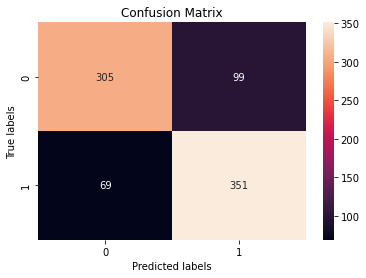

In [135]:
cm=metrics.confusion_matrix(y_test, plg1_prediction)
cmplot(cm)

In [136]:
print("Accuracy:",metrics.accuracy_score(y_test, plg1_prediction))
print("Precision:",metrics.precision_score(y_test, plg1_prediction))
print("Recall:",metrics.recall_score(y_test, plg1_prediction))
print("Specificity:", metrics.recall_score(y_test, plg1_prediction,pos_label=0))
print("F1 Score: ",metrics.f1_score(y_test,plg1_prediction))

Accuracy: 0.7961165048543689
Precision: 0.78
Recall: 0.8357142857142857
Specificity: 0.754950495049505
F1 Score:  0.806896551724138


In [115]:
metrics.roc_auc_score(y_test, plg1_prediction)

0.794094766619519

In [131]:
metrics.confusion_matrix(y_test, plg2_prediction)

array([[335,  69],
       [105, 315]])

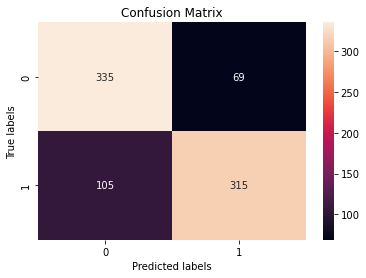

In [132]:
cm=metrics.confusion_matrix(y_test, plg2_prediction)
cmplot(cm)

In [133]:
print("Accuracy:",metrics.accuracy_score(y_test, plg2_prediction))
print("Precision:",metrics.precision_score(y_test, plg2_prediction))
print("Recall:",metrics.recall_score(y_test, plg2_prediction))
print("Specificity:", metrics.recall_score(y_test, plg2_prediction,pos_label=0))
print("F1 Score: ",metrics.f1_score(y_test,plg2_prediction))

Accuracy: 0.7888349514563107
Precision: 0.8203125
Recall: 0.75
Specificity: 0.8292079207920792
F1 Score:  0.7835820895522388


In [103]:
metrics.roc_curve(y_test, plg2_prediction)

(array([0.        , 0.17821782, 1.        ]),
 array([0.       , 0.7547619, 1.       ]),
 array([2, 1, 0]))

In [104]:
metrics.roc_auc_score(y_test, plg2_prediction)

0.7882720414898633

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(pipe2_LG, X, ylabels,cv=2)

In [ ]:
scores

In [105]:
example = ["I do enjoy my job",
 "What a poor product!,I will have to get a new one",
 "I feel amazing!",
 "This class sucks"]

pipe2_LG.predict(example)

array([1, 0, 1, 0])

In [106]:
pipe2_LG.decision_function
pipe2_LG.predict_proba(example)

array([[0.24217368, 0.75782632],
       [0.83872248, 0.16127752],
       [0.19692501, 0.80307499],
       [0.73545333, 0.26454667]])

In [ ]:
pipe2_LG
pipe2_LG.decision_function
pipe2_LG.steps[2][1].coef_

In [ ]:
pipe2_LG.steps[2][1].coef_.shape
pipe2_LG.steps[1][1].vocabulary_#3270

## MultiLayer Perceptron 

In [ ]:
# Multi layer perceptron
from sklearn.neural_network import MLPClassifier

classifier_MLP =  MLPClassifier(max_iter=400, hidden_layer_sizes=(100,2), verbose=True)

In [ ]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe1_mlp = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow),
                 ('classifier', classifier_MLP)], verbose=True)

pipe2_mlp = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfvectorizer),
                 ('classifier', classifier_MLP)], verbose=True)

In [ ]:
pipe1_mlp.fit(X_train,y_train)
pipe2_mlp.fit(X_train,y_train)

In [ ]:
mlp1_prediction = pipe1_mlp.predict(X_test)
mlp2_prediction = pipe2_mlp.predict(X_test)

In [ ]:
metrics.confusion_matrix(y_test, mlp1_prediction)

In [ ]:
cm=metrics.confusion_matrix(y_test, mlp1_prediction)
cmplot(cm)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, mlp1_prediction))
print("Precision:",metrics.precision_score(y_test, mlp1_prediction))
print("Recall:",metrics.recall_score(y_test, mlp1_prediction))
print("Specificity:", metrics.recall_score(y_test, mlp1_prediction,pos_label=0))
print("F1 Score: ",metrics.f1_score(y_test,mlp1_prediction))

In [ ]:
metrics.confusion_matrix(y_test, mlp2_prediction)

In [ ]:
cm=metrics.confusion_matrix(y_test, mlp2_prediction)
cmplot(cm)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, mlp2_prediction))
print("Precision:",metrics.precision_score(y_test, mlp2_prediction))
print("Recall:",metrics.recall_score(y_test, mlp2_prediction))
print("Specificity:", metrics.recall_score(y_test, mlp2_prediction,pos_label=0))
print("F1 Score: ",metrics.f1_score(y_test,mlp2_prediction))

In [ ]:
example = ["I do enjoy my job",
 "What a poor product!,I will have to get a new one",
 "I feel amazing!",
 "This class sucks"]

#pipe2_mlp.predict(example)

# Save Model

In [ ]:
import joblib

In [ ]:
joblib.dump(pipe2_LG, "model/logreg_tfidf2.pkl")

In [ ]:
logreg_loaded = joblib.load("model/logreg_tfidf.pkl")

In [ ]:
logreg_loaded.predict(example)

In [ ]:
joblib.dump(pipe2, "mlp_tfidf.pkl")

In [ ]:
mlp_loaded = joblib.load("mlp_tfidf.pkl")

In [ ]:
mlp_loaded.predict(example)